In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import time
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import cv2
import shutil
from tensorflow.keras.models import Sequential


from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                        Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN, LSTM, GlobalAveragePooling2D, SeparableConv2D, ZeroPadding2D, Convolution2D, ZeroPadding2D
from keras import models
from keras import layers
from keras.preprocessing import image

base Path ( where our Dataset have)

In [22]:
base_path = 'Indian_new/'

### Create array name filepaths and classes, where our path location store in filpath and it's label value stored in labels 

In [24]:
classes = os.listdir(base_path)
filepaths = []
labels = []
for d in classes:
    flist = os.listdir(base_path + d)
    for f in flist:
        fpath = os.path.join(base_path + d + '/' + f)
        filepaths.append(fpath)
        labels.append(d)

### Convert these value to DataFrame

In [25]:
Fseries=pd.Series(filepaths, name='file_paths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries,Lseries], axis=1)
df=pd.DataFrame(np.array(df).reshape(7092,2), columns = ['file_paths', 'labels'])

### Split Data into Train and test

In [26]:
X_Train,X_Test = train_test_split(df,train_size=0.9,random_state=123,shuffle=True)

In [27]:
print(X_Train.head())

                file_paths labels
6524   Indian_new/W/85.jpg      W
1277   Indian_new/7/39.jpg      7
2881    Indian_new/E/9.jpg      E
3625  Indian_new/I/126.jpg      I
2088   Indian_new/B/78.jpg      B


### IMAGE DATA GENERATOR  FOR TRAIN IMAGE

In [10]:
Train_IMG_Generator = ImageDataGenerator(rescale=1./255,
                                        zoom_range=0.5,
                                        shear_range=0.5,
                                        brightness_range=[0.6,1.0],
                                        rotation_range=35,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        vertical_flip=True,
                                         featurewise_std_normalization=False,
                                         samplewise_center=False,
                                         samplewise_std_normalization=False,
                                        fill_mode="nearest",
                                        validation_split=0.1)

### IMAGE DATA GENERATOR FOR TEST IMAGE

In [28]:
Test_IMG_Generator = ImageDataGenerator(rescale=1./255)

### IMAGE DATA GENERATOR PROCESS

In [29]:
Train_Set = Train_IMG_Generator.flow_from_dataframe(dataframe=X_Train,
                                                   x_col="file_paths",
                                                   y_col="labels",
                                                   batch_size=32,
                                                   class_mode="categorical",
                                                   color_mode="grayscale",
                                                   subset="training")

Found 5744 validated image filenames belonging to 35 classes.


In [30]:
Validation_Set = Train_IMG_Generator.flow_from_dataframe(dataframe=X_Train,
                                                   x_col="file_paths",
                                                   y_col="labels",
                                                   batch_size=32,
                                                   class_mode="categorical",
                                                   color_mode="grayscale",
                                                   subset="validation")

Found 638 validated image filenames belonging to 35 classes.


In [31]:
Test_Set = Test_IMG_Generator.flow_from_dataframe(dataframe=X_Test,
                                                   x_col="file_paths",
                                                   y_col="labels",
                                                   batch_size=32,
                                                   class_mode="categorical",
                                                   color_mode="grayscale",
                                                   shuffle=False)

Found 710 validated image filenames belonging to 35 classes.


## LOOK BY GENERATOR

(128, 128, 3)


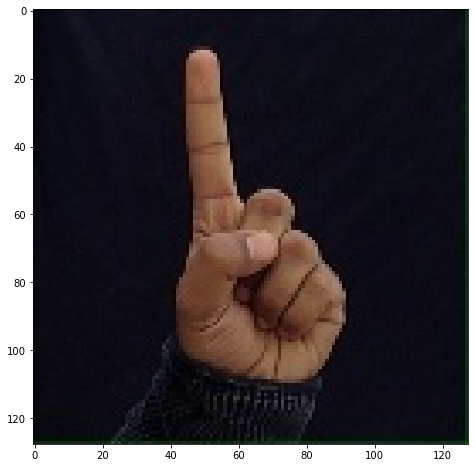

In [32]:
figure = plt.figure(figsize = (8,8))
Example_Image = cv2.imread('0.jpg')
Example_Image = cv2.cvtColor(Example_Image,cv2.COLOR_BGR2RGB)
plt.imshow(Example_Image)
print(Example_Image.shape)

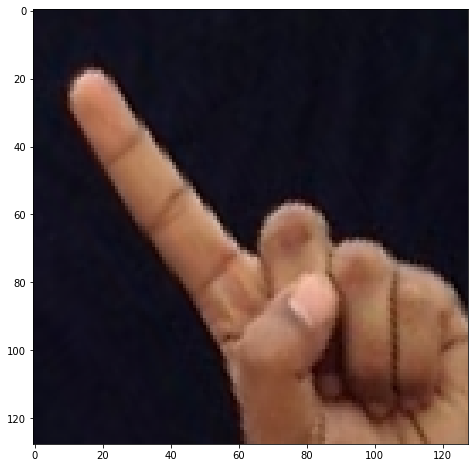

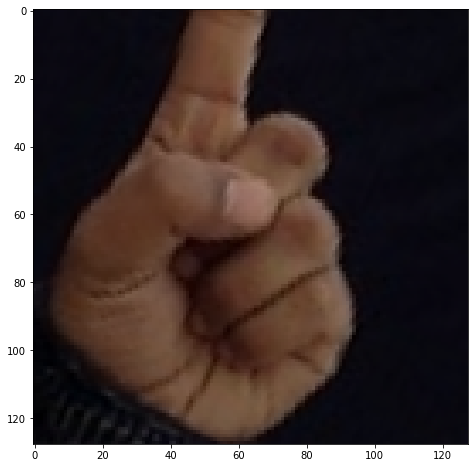

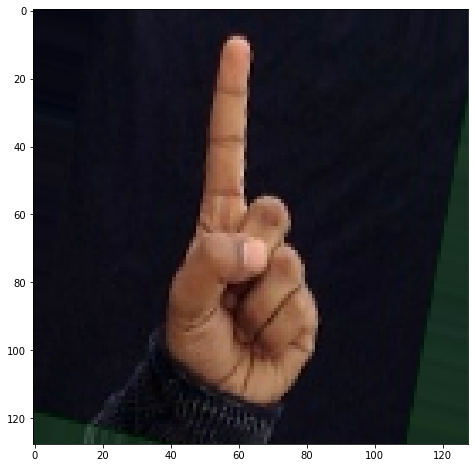

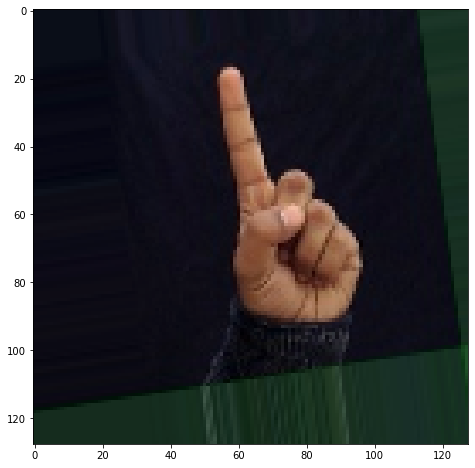

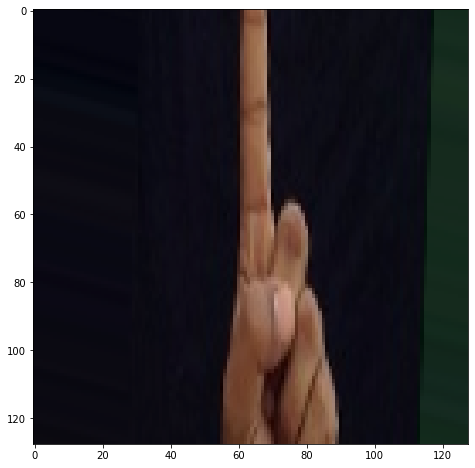

In [33]:
test_image = Example_Image.reshape((1,) + Example_Image.shape)

i = 0

for batch in Train_IMG_Generator.flow(test_image,batch_size = 1):
    figure = plt.figure(figsize = (8,8))
    plt.imshow(image.img_to_array(batch[0]))
    
    i +=1
    if i == 5:
        break
plt.show()

## Create Model

In [34]:
COMPILE_OPTIMIZER = "adam"
COMPILE_LOSS = "categorical_crossentropy"
COMPILE_METRICS = ["accuracy"]
INPUT_DIM = (256,256,1)
OUTPUT_DIM = 35

In [35]:
Early_Stopper = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")
Checkpoint_Model = tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      filepath="./modelcheck")

In [36]:
Model = Sequential()

In [37]:
Model.add(Conv2D(24,(3,3),activation="relu",input_shape=INPUT_DIM))
Model.add(BatchNormalization())
Model.add(MaxPooling2D((2,2),strides=2))

Model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
Model.add(Dropout(0.3))
Model.add(MaxPooling2D((2,2),strides=2))

Model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
Model.add(Dropout(0.3))
Model.add(MaxPooling2D((2,2),strides=2))

Model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
Model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
Model.add(Dropout(0.3))
Model.add(MaxPooling2D((2,2),strides=2))

Model.add(Conv2D(256,(3,3),activation="relu",padding="same"))
Model.add(Dropout(0.3))
Model.add(MaxPooling2D((2,2),strides=2))

Model.add(Flatten())
Model.add(Dense(2352,activation="relu"))
Model.add(Dropout(0.5))
Model.add(Dense(OUTPUT_DIM,activation="softmax"))

In [38]:
Model.compile(optimizer=COMPILE_OPTIMIZER,loss=COMPILE_LOSS,metrics=COMPILE_METRICS)

Validation_data = Data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be   trained on this data

In [39]:
CNN_Model = Model.fit(Train_Set,
                      validation_data=Validation_Set,
                      callbacks=[Early_Stopper,Checkpoint_Model],
                      epochs=50)

Epoch 1/50
180/180 [==============================] - 498s 3s/step - loss: 2.8351 - accuracy: 0.2107 - val_loss: 3.6056 - val_accuracy: 0.0611
Epoch 2/50
180/180 [==============================] - 498s 3s/step - loss: 1.2326 - accuracy: 0.6243 - val_loss: 3.0908 - val_accuracy: 0.1003
Epoch 3/50
180/180 [==============================] - 494s 3s/step - loss: 0.6403 - accuracy: 0.7972 - val_loss: 1.8771 - val_accuracy: 0.6944
Epoch 4/50
180/180 [==============================] - 493s 3s/step - loss: 0.4088 - accuracy: 0.8700 - val_loss: 0.7891 - val_accuracy: 0.8652
Epoch 5/50
180/180 [==============================] - 488s 3s/step - loss: 0.3019 - accuracy: 0.9063 - val_loss: 0.6172 - val_accuracy: 0.9467
Epoch 6/50
180/180 [==============================] - 492s 3s/step - loss: 0.2490 - accuracy: 0.9220 - val_loss: 0.3854 - val_accuracy: 0.9545
Epoch 7/50
180/180 [==============================] - 488s 3s/step - loss: 0.1914 - accuracy: 0.9450 - val_loss: 0.6158 - val_accuracy: 0.9028

In [42]:
Model.save("Pawan_Model.h5")

In [43]:
Model_Results = Model.evaluate(Test_Set)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.2f" % Model_Results[1])

23/23 [==============================] - 11s 458ms/step - loss: 0.0401 - accuracy: 0.9986
LOSS:  0.0401
ACCURACY:  1.00
